### ShuffleNEt

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import random
from tqdm import tqdm
import xgboost as xgb
import tensorflow as tf
from keras.applications.resnet50 import ResNet50
# from keras.applications.resnet18 import ResNet18
from keras.models import Model
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers import Flatten, Input
import scipy
from sklearn.metrics import fbeta_score
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import xgboost

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import keras
from tqdm import tqdm
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input
from keras.models import Model,Sequential,  load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
#from keras.optimizers import adam_v2
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications.vgg16 import VGG16

In [59]:
disease_types=['Apple___Apple_scab','Apple___Black_rot', 'Apple___Cedar_apple_rust','Apple___healthy',
               'Grape___healthy', 'Grape___Leaf_blight', 'Grape___Esca', 'Grape___Black_rot',
               'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight']

data_dir = '/content/drive/MyDrive/BitkiHastaligiTeshisi - OzgeOzaras/Mini_SqueezeNet_New/Kodlar/dataset'
train_dir = os.path.join(data_dir)

train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])

train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])

SEED = 42
train = train.sample(frac=1, random_state=SEED)
train.index = np.arange(len(train)) # Reset indices

In [60]:
IMAGE_SIZE = 224
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) # Loading a color image is the default flag
# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [61]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X_Train = X_train / 255.
print('Train Shape: {}'.format(X_Train.shape))

9385it [01:03, 147.94it/s]


Train Shape: (9385, 224, 224, 3)


In [62]:
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train)

In [63]:
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state=SEED)

In [25]:
EPOCHS = 100
BATCH_SIZE=64
SIZE=224
N_ch=3

In [26]:
from keras import backend as K
K.clear_session()

In [27]:
pip install Keras

In [28]:
pip install keras_applications

In [29]:

from keras.utils import plot_model
from keras_applications.imagenet_utils import _obtain_input_shape
#from tensorflow.keras.engine.topology import get_source_inputs
from keras.layers import Input, Conv2D, MaxPool2D, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.layers import Activation, Dense
from keras.models import Model
import keras.backend as K
import os
from keras import backend as K
from keras.models import Model
#from keras.engine.topology import get_source_inputs
from keras.layers import Activation, Add, Concatenate, Conv2D, GlobalMaxPooling2D
from keras.layers import GlobalAveragePooling2D,Input, Dense
from keras.layers import MaxPool2D,AveragePooling2D, BatchNormalization, Lambda, DepthwiseConv2D
import numpy as np
from keras.layers import Lambda

def channel_split(inputs, name):
    """Splits the input tensor into two parts along the channel axis."""
    channel_axis = -1 if K.image_data_format() == 'channels_last' else 1

    # Calculate the number of channels and split size
    channels = tf.keras.backend.int_shape(inputs)[channel_axis]
    split_channels = channels // 2

    # Use Lambda layers to split the channels
    return Lambda(lambda x: x[..., :split_channels], name=name + '_split1')(inputs), \
           Lambda(lambda x: x[..., split_channels:], name=name + '_split2')(inputs)

def channel_shuffle(x):
    height, width, channels = x.shape[1:]  # Tuple'dan boyutları al
    channels_per_split = channels // 2
    x = tf.reshape(x, [-1, height, width, 2, channels_per_split])  # tf.reshape kullan
    x = tf.transpose(x, perm=[0, 1, 2, 4, 3])  # Permute to shuffle channels
    x = tf.reshape(x, [-1, height, width, channels])  # tf.reshape kullan
    return x

def shuffle_unit(inputs, out_channels, bottleneck_ratio, strides=2, stage=1, block=1):
    if K.image_data_format() == 'channels_last':
        bn_axis = -1
    else:
        raise ValueError('Only channels last supported')

    prefix = 'stage{}-block{}'.format(stage, block)
    bottleneck_channels = int(out_channels * bottleneck_ratio)

    if strides < 2:
        c_hat, c = channel_split(inputs, '{}_spl'.format(prefix))
        inputs = c

    x = Conv2D(bottleneck_channels, kernel_size=(1, 1), strides=1, padding='same', name='{}_1x1conv_1'.format(prefix))(inputs)
    x = BatchNormalization(axis=bn_axis, name='{}_bn_1x1conv_1'.format(prefix))(x)
    x = Activation('relu', name='{}_relu_1x1conv_1'.format(prefix))(x)
    x = DepthwiseConv2D(kernel_size=3, strides=strides, padding='same', name='{}_3x3dwconv'.format(prefix))(x)
    x = BatchNormalization(axis=bn_axis, name='{}_bn_3x3dwconv'.format(prefix))(x)
    x = Conv2D(bottleneck_channels, kernel_size=1, strides=1, padding='same', name='{}_1x1conv_2'.format(prefix))(x)
    x = BatchNormalization(axis=bn_axis, name='{}_bn_1x1conv_2'.format(prefix))(x)
    x = Activation('relu', name='{}_relu_1x1conv_2'.format(prefix))(x)

    if strides < 2:
        ret = Concatenate(axis=bn_axis, name='{}_concat_1'.format(prefix))([x, c_hat])
    else:
        s2 = DepthwiseConv2D(kernel_size=3, strides=2, padding='same', name='{}_3x3dwconv_2'.format(prefix))(inputs)
        s2 = BatchNormalization(axis=bn_axis, name='{}_bn_3x3dwconv_2'.format(prefix))(s2)
        s2 = Conv2D(bottleneck_channels, kernel_size=1, strides=1, padding='same', name='{}_1x1_conv_3'.format(prefix))(s2)
        s2 = BatchNormalization(axis=bn_axis, name='{}_bn_1x1conv_3'.format(prefix))(s2)
        s2 = Activation('relu', name='{}_relu_1x1conv_3'.format(prefix))(s2)
        ret = Concatenate(axis=bn_axis, name='{}_concat_2'.format(prefix))([x, s2])

    # tf.keras.backend.int_shape ile output_shape belirleyin
    ret_shape = tf.keras.backend.int_shape(ret)
    ret = Lambda(channel_shuffle, output_shape=(ret_shape[1], ret_shape[2], ret_shape[3]), name='{}_channel_shuffle'.format(prefix))(ret)

    return ret

def block(x, channel_map, bottleneck_ratio, repeat=1, stage=1):
    x = shuffle_unit(x, out_channels=channel_map[stage-1],
                      strides=2,bottleneck_ratio=bottleneck_ratio,stage=stage,block=1)

    for i in range(1, repeat+1):
        x = shuffle_unit(x, out_channels=channel_map[stage-1],strides=1,
                          bottleneck_ratio=bottleneck_ratio,stage=stage, block=(1+i))

    return x


def ShuffleNetV2(include_top=True,
                 input_tensor=None,
                 scale_factor=1.0,
                 pooling='max',
                 input_shape=(224,224,3),
                 load_model=None,
                 num_shuffle_units=[3,7,3],
                 bottleneck_ratio=1,
                 classes=11):
    if K.backend() != 'tensorflow':
        raise RuntimeError('Only tensorflow supported for now')
    name = 'ShuffleNetV2_{}_{}_{}'.format(scale_factor, bottleneck_ratio, "".join([str(x) for x in num_shuffle_units]))
    input_shape = _obtain_input_shape(input_shape, default_size=224, min_size=28, require_flatten=include_top,
                                      data_format=K.image_data_format())
    out_dim_stage_two = {0.5:48, 1:116, 1.5:176, 2:244}

    if pooling not in ['max', 'avg']:
        raise ValueError('Invalid value for pooling')
    if not (float(scale_factor)*4).is_integer():
        raise ValueError('Invalid value for scale_factor, should be x over 4')
    exp = np.insert(np.arange(len(num_shuffle_units), dtype=np.float32), 0, 0)  # [0., 0., 1., 2.]
    out_channels_in_stage = 2**exp
    out_channels_in_stage *= out_dim_stage_two[bottleneck_ratio]  #  calculate output channels for each stage
    out_channels_in_stage[0] = 24  # first stage has always 24 output channels
    out_channels_in_stage *= scale_factor
    out_channels_in_stage = out_channels_in_stage.astype(int)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    # create shufflenet architecture
    x = Conv2D(filters=out_channels_in_stage[0], kernel_size=(3, 3), padding='same', use_bias=False, strides=(2, 2),
               activation='relu', name='conv1')(img_input)
    x = MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same', name='maxpool1')(x)

    # create stages containing shufflenet units beginning at stage 2
    for stage in range(len(num_shuffle_units)):
        repeat = num_shuffle_units[stage]
        x = block(x, out_channels_in_stage,
                   repeat=repeat,
                   bottleneck_ratio=bottleneck_ratio,
                   stage=stage + 2)

    if bottleneck_ratio < 2:
        k = 1024
    else:
        k = 2048
    x = Conv2D(k, kernel_size=1, padding='same', strides=1, name='1x1conv5_out', activation='relu')(x)

    if pooling == 'avg':
        x = GlobalAveragePooling2D(name='global_avg_pool')(x)
    elif pooling == 'max':
        x = GlobalMaxPooling2D(name='global_max_pool')(x)

    if include_top:
        x = Dense(classes, name='fc')(x)
        x = Activation('softmax', name='softmax')(x)

    if input_tensor:
        inputs = get_source_inputs(input_tensor)

    else:
        inputs = img_input

    model = Model(inputs, x, name=name)

    if load_model:
        model.load_weights('imagenet', by_name=True)

    return model


In [30]:
model = ShuffleNetV2(input_shape=(224, 224, 3), classes=11)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print(model.summary())

Model: "ShuffleNetV2_1.0_1_373"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1 (Conv2D)            │ (None, 112, 112, 24)   │            648 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ maxpool1 (MaxPooling2D)   │ (None, 56, 56, 24)     │              0 │ conv1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage2-block1_1x1conv_1   │ (None, 56, 56, 116)    │          2,900 │ maxpool1[0][0]         │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage2-block1_bn_1x1conv… │ (None, 56, 56, 116)    │            464 │ stage2-block1_1x1conv… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage2-block1_relu_1x1co… │ (None, 56, 56, 116)    │              0 │ stage2-block1_bn_1x1c… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage2-block1_3x3dwconv   │ (None, 28, 28, 116)    │          1,160 │ stage2-block1_relu_1x… │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage2-block1_3x3dwconv_2 │ (None, 28, 28, 24)     │            240 │ maxpool1[0][0]         │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage2-block1_bn_3x3dwco… │ (None, 28, 28, 116)    │            464 │ stage2-block1_3x3dwco… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage2-block1_bn_3x3dwco… │ (None, 28, 28, 24)     │             96 │ stage2-block1_3x3dwco… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage2-block1_1x1conv_2   │ (None, 28, 28, 116)    │         13,572 │ stage2-block1_bn_3x3d… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage2-block1_1x1_conv_3  │ (None, 28, 28, 116)    │          2,900 │ stage2-block1_bn_3x3d… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage2-block1_bn_1x1conv… │ (None, 28, 28, 116)    │            464 │ stage2-block1_1x1conv… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage2-block1_bn_1x1conv… │ (None, 28, 28, 116)    │            464 │ stage2-block1_1x1_con… │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 4,030,015 (15.37 MB)

 Trainable params: 4,001,895 (15.27 MB)

 Non-trainable params: 28,120 (109.84 KB)

None


In [31]:
EPOCHS = 100
BATCH_SIZE=64
SIZE=224
N_ch=3

In [32]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print(model.summary())

Model: "ShuffleNetV2_1.0_1_373"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1 (Conv2D)            │ (None, 112, 112, 24)   │            648 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ maxpool1 (MaxPooling2D)   │ (None, 56, 56, 24)     │              0 │ conv1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage2-block1_1x1conv_1   │ (None, 56, 56, 116)    │          2,900 │ maxpool1[0][0]         │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage2-block1_bn_1x1conv… │ (None, 56, 56, 116)    │            464 │ stage2-block1_1x1conv… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage2-block1_relu_1x1co… │ (None, 56, 56, 116)    │              0 │ stage2-block1_bn_1x1c… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage2-block1_3x3dwconv   │ (None, 28, 28, 116)    │          1,160 │ stage2-block1_relu_1x… │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage2-block1_3x3dwconv_2 │ (None, 28, 28, 24)     │            240 │ maxpool1[0][0]         │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage2-block1_bn_3x3dwco… │ (None, 28, 28, 116)    │            464 │ stage2-block1_3x3dwco… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage2-block1_bn_3x3dwco… │ (None, 28, 28, 24)     │             96 │ stage2-block1_3x3dwco… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage2-block1_1x1conv_2   │ (None, 28, 28, 116)    │         13,572 │ stage2-block1_bn_3x3d… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage2-block1_1x1_conv_3  │ (None, 28, 28, 116)    │          2,900 │ stage2-block1_bn_3x3d… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage2-block1_bn_1x1conv… │ (None, 28, 28, 116)    │            464 │ stage2-block1_1x1conv… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage2-block1_bn_1x1conv… │ (None, 28, 28, 116)    │            464 │ stage2-block1_1x1_con… │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 4,030,015 (15.37 MB)

 Trainable params: 4,001,895 (15.27 MB)

 Non-trainable params: 28,120 (109.84 KB)

None


In [33]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)

# Update filepath to use .keras extension
mc = ModelCheckpoint('best_model.keras', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# You can now fit your model and include these callbacks
# Example:
# model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=100, callbacks=[es, mc])


In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [34]:
hist=model.fit(X_train, Y_train,
               batch_size=BATCH_SIZE,
               epochs=EPOCHS,
               verbose=1,
               validation_data=(X_val, Y_val),
               callbacks=[es,mc])

Epoch 1/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.3211 - loss: 2.8618
Epoch 1: val_accuracy improved from -inf to 0.10975, saving model to best_model.keras
118/118 ━━━━━━━━━━━━━━━━━━━━ 97s 329ms/step - accuracy: 0.3225 - loss: 2.8536 - val_accuracy: 0.1097 - val_loss: 2.4068
Epoch 2/100
117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7486 - loss: 0.7037
Epoch 2: val_accuracy improved from 0.10975 to 0.13426, saving model to best_model.keras
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.7491 - loss: 0.7028 - val_accuracy: 0.1343 - val_loss: 2.3677
Epoch 3/100
117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8630 - loss: 0.4059
Epoch 3: val_accuracy did not improve from 0.13426
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.8631 - loss: 0.4054 - val_accuracy: 0.1343 - val_loss: 2.3695
Epoch 4/100
117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9169 - loss: 0.2255
Epoch 4: val_accuracy did not improve from 0.13426
118/118 ━━━━━━

In [64]:
from keras import config

config.enable_unsafe_deserialization()

# Now load the model
saved_model = load_model('best_model.keras', custom_objects={'channel_shuffle': channel_shuffle})



In [71]:
y_pred = saved_model.predict(X_val)

59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step


In [72]:
y_pred=np.argmax(y_pred, axis=1)

In [67]:
Y_val=np.argmax(Y_val, axis=-1)

In [73]:

print("Doğruluk: ",accuracy_score(Y_val, y_pred))
print("F1_Skor: ", f1_score(Y_val, y_pred,average="macro"))
print("Hassasiyet: ",precision_score(Y_val, y_pred,average="macro"))
print("Duyarlılık: ", recall_score(Y_val, y_pred,average="macro"))

Doğruluk:  0.9946723494938732
F1_Skor:  0.9939317127364028
Hassasiyet:  0.9955083531467236
Duyarlılık:  0.9924300062003344


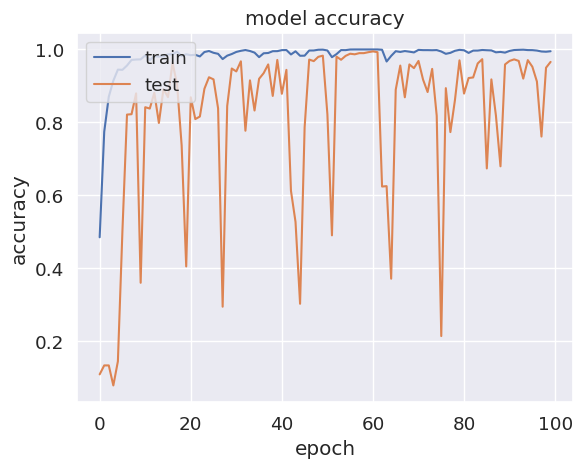

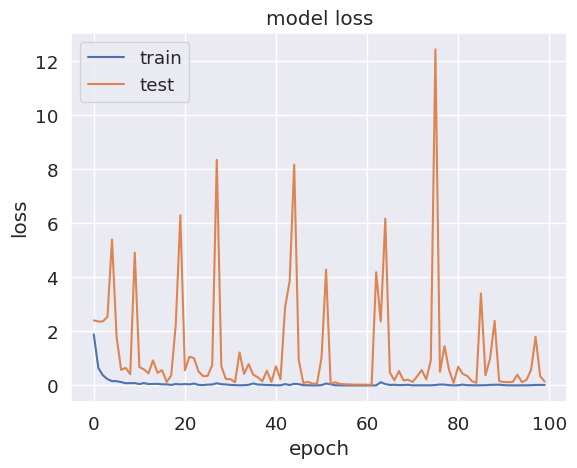

In [74]:

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

[[116   0   0   2   0   0   0   0   0   0   0]
 [  0 129   0   0   0   0   0   0   0   0   0]
 [  0   0  52   0   0   0   0   0   0   0   0]
 [  1   0   0 361   0   0   0   0   0   0   0]
 [  0   0   0   0  77   0   0   0   0   0   0]
 [  0   0   0   0   0 213   0   1   0   0   0]
 [  0   0   0   0   0   0 255   0   0   0   0]
 [  0   0   0   0   0   0   0 252   0   0   0]
 [  0   0   0   1   0   0   0   0 180   0   1]
 [  0   0   0   0   1   0   0   0   0  29   0]
 [  0   0   0   2   0   0   0   0   1   0 203]]


<Axes: >

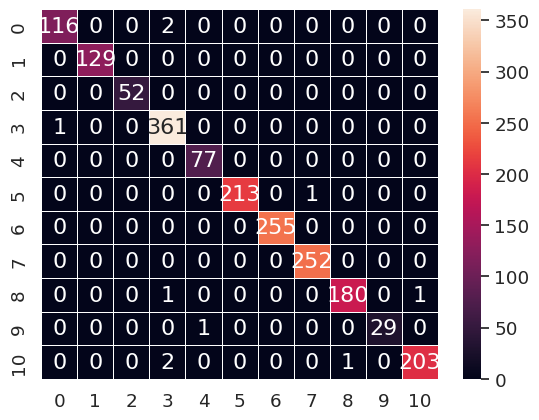

In [75]:
import seaborn as sn
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(Y_val, y_pred)
print(cm)
sn.set(font_scale=1.2)#for label size
sn.heatmap(cm, annot=True,fmt="d", linewidths=.5 ,annot_kws={"size": 16})# font size